In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.optimize import curve_fit as cv
import numpy as np
# import library
import pickle

# Lab 6
> For the LHC data, we are going to have to fake a background. Make a Poisson background with mean 100. 

In [18]:
poisson_background = stats.poisson.rvs(mu=100, size = 10000)

## Problem 1
> The first problem is to look at your background distribution and determine where the $5\sigma$ sensitivity threshold is.

In [19]:
# first, find the probability corrosponding to 5 sigma
five_sigma_prob = stats.norm.cdf(5)
# calculate where that cutoff falls in our background
cut_off = stats.poisson.ppf(five_sigma_prob, 100)
print('5-sigma cut off: ',cut_off)

5-sigma cut off:  154.0


## Problem 2
> Now create a set of injected (simulated) signals of a single strength. You will want to make your signal moderately strong, say somewhere in the 8-30 $5\sigma$ range. Inject this signal into your background data many times.

I'm going to create a signal of strength $8 \sigma$ and add 100 samples of this to my background.

In [20]:
eight_sigma_prob = stats.norm.cdf(8)
eight_sigma_value = stats.poisson.ppf(eight_sigma_prob, 100)
print('8-sigma cut off: ',eight_sigma_value)

one_signal = poisson_background.copy()

for times in range(100):
    one_signal = np.append(one_signal, eight_sigma_value + stats.poisson.rvs(100))

8-sigma cut off:  190.0


> a) Histogram how bright the observed signal appears to be, and discuss it's shape. Say in words what this histogram is telling you.

Text(0, 0.5, 'log[Frequency]')

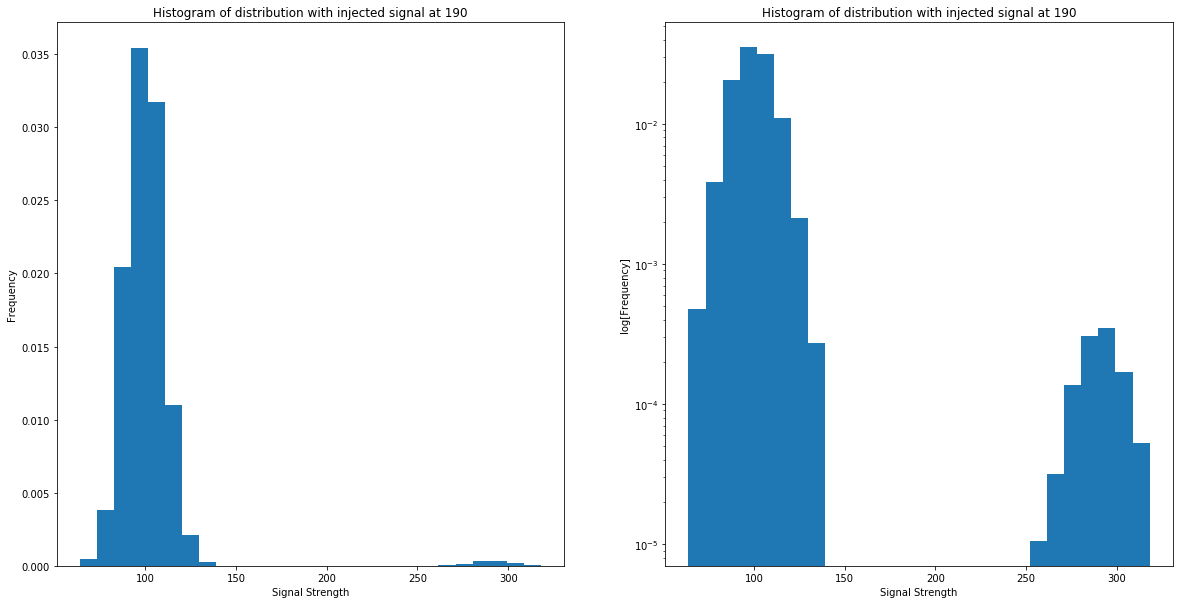

In [29]:
plt.rcParams["figure.figsize"] = (20,10)  
fig, ax = plt.subplots(1, 2)


hist = ax[0].hist(one_signal, density=True, bins = 27)
log_hist = ax[1].hist(one_signal, density=True, bins = 27)
ax[1].set_yscale('log')
ax[0].set_title('Histogram of distribution with injected signal at 190')
ax[1].set_title('Histogram of distribution with injected signal at 190')
ax[0].set_xlabel('Signal Strength')
ax[1].set_xlabel('Signal Strength')
ax[0].set_ylabel('Frequency')
ax[1].set_ylabel('log[Frequency]')

When the $\mu$ for a Poisson distribution is high, it tends to look like a normal distribution.  What we can see from this histogram is that there is an extreme outlier to the right of the distribution.

> b) Is your observed signal biased? (e.g. is the observed value equally likely to be stronger or weaker than the true injected signal?) Is it symmetric?

Yes, the observed signal is biased because it is much more likely to observe a value less than our signal than greater than our signal.  It is not symmetric via the same logic.

## Problem 3

> Now make a suite of injected signals. You will want to have a range of injected signal strengths, starting at zero and extending well above $5 \sigma$ ($30 \sigma$ or more).

> a) Clearly state what you are simulating, and make a 2D histogram of injected signal vs. observed signal



In [3]:
def make_pdfs(max_signal):
    size = 1000

    observed = np.zeros(size*size)
    signals = np.zeros(size*size)

    for index in range(size):
        signal = (max_signal / size) * index
        for times in range(size):
            signals[index*size + times] = signal
            observed[index*size + times] = stats.poisson.rvs(mu=100) + signal
            
    return [observed, signals]

In [4]:
[observed, injected_signals] = make_pdfs(500)

Text(0.5, 1.0, 'Confidence intervals')

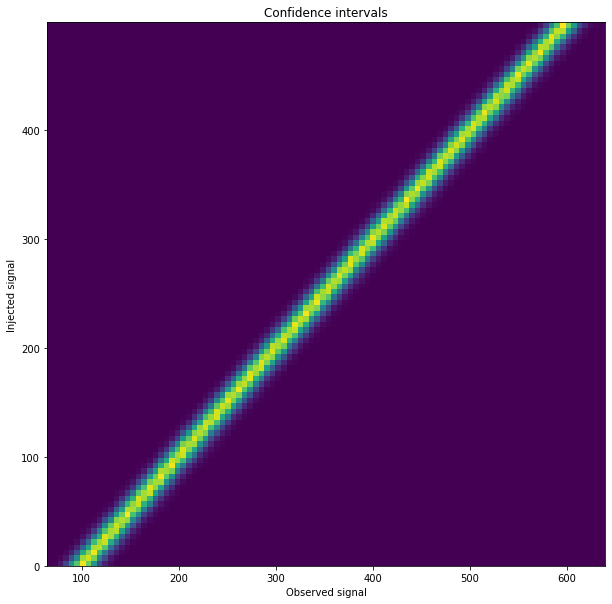

In [5]:
plt.rcParams["figure.figsize"] = (10,10)  
fig, ax = plt.subplots(1, 1)

hist = ax.hist2d(observed, injected_signals, bins=100)[0]
ax.set_xlabel('Observed signal')
ax.set_ylabel('Injected signal')
ax.set_title('Confidence intervals')
        

> b) If you choose the same injected signal power as in problem 2, show that you get the same answer.

Text(0, 0.5, 'log[Frequency]')

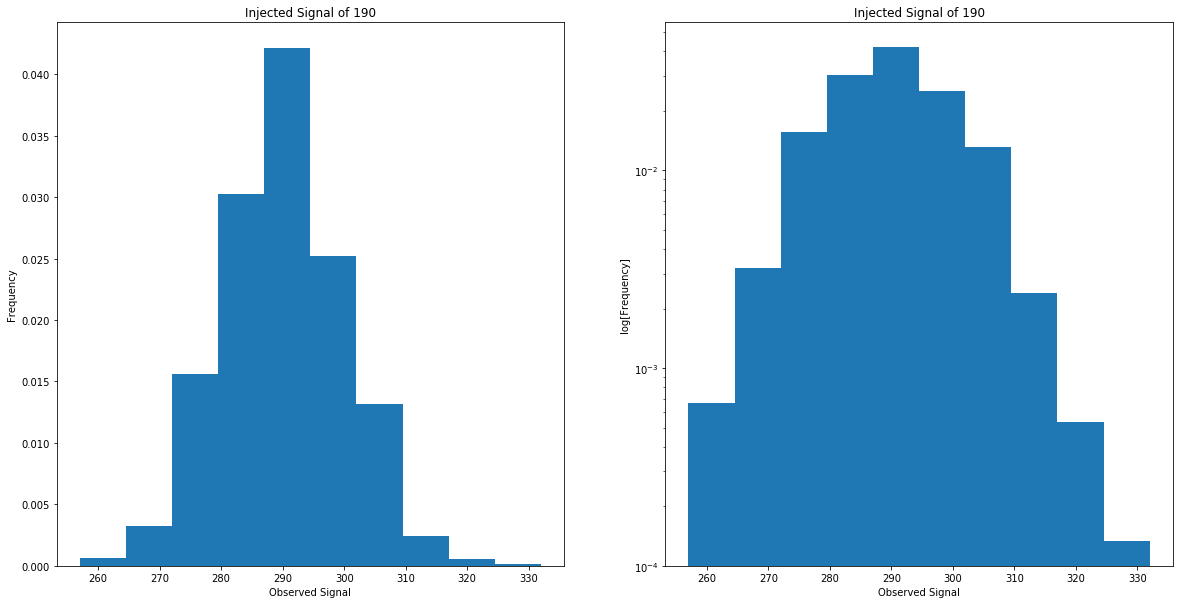

In [28]:
plt.rcParams["figure.figsize"] = (20,10)  
fig, ax = plt.subplots(1, 2)

signal = 190
dist = []

for index in range(injected_signals.size):
    if injected_signals[index] == signal:
        dist.append(observed[index])


ax[0].hist(dist, bins=10, density = True)
ax[0].set_title('Injected Signal of ' + str(signal))
ax[0].set_xlabel('Observed Signal')
ax[0].set_ylabel('Frequency')

ax[1].hist(dist, bins=10, density = True)
ax[1].set_yscale('log')
ax[1].set_title('Injected Signal of ' + str(signal))
ax[1].set_xlabel('Observed Signal')
ax[1].set_ylabel('log[Frequency]')

The distribution has a mean equal to the mean of the background plus the strength of the signal

> c) Now reverse the problem, select an observed signal (pick something quite a bit stronger than 5$\sigma$) and create a 1D histogram of the injected signal pdf(). Describe the meaning of this histogram.

Let's take an observed signal of 250 ($\approx15\sigma$).  To answer this, we want to take our observed signal and find all of the injected signals that corrospond to that value.

Text(0, 0.5, 'log[Frequency]')

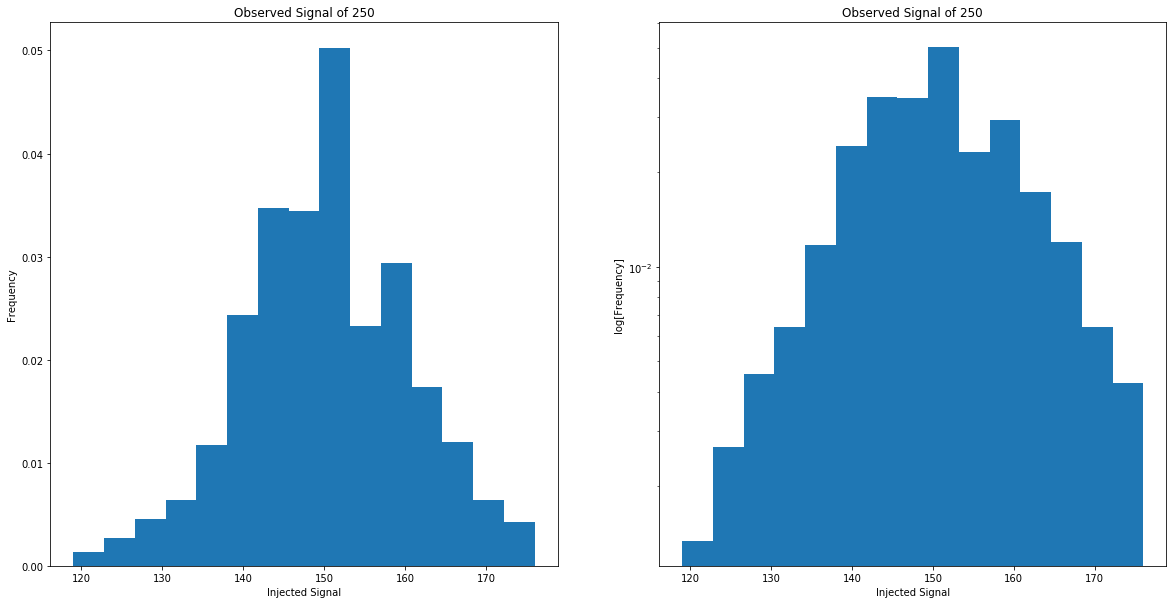

In [33]:
signal = 250

vert_dist = []

for index in range(observed.size):
    if observed[index] == signal:
        vert_dist.append(injected_signals[index])

plt.rcParams["figure.figsize"] = (20,10)  
fig, ax = plt.subplots(1, 2)

ax[0].hist(vert_dist, bins=15, density=True)
ax[0].set_title('Observed Signal of ' + str(signal))
ax[0].set_xlabel('Injected Signal')
ax[0].set_ylabel('Frequency')

ax[1].hist(vert_dist, bins=15, density=True)
ax[1].set_yscale('log')
ax[1].set_title('Observed Signal of ' + str(signal))
ax[1].set_xlabel('Injected Signal')
ax[1].set_ylabel('log[Frequency]')

This histogram shows us that if our observed signal is 250, then our injected signal is about 150, which is consistent with our background signal having a mean of 100.

> d) For your observed signal, what is the $1\sigma$ uncertainty on the true signal strength?

To find the $1\sigma$, we need to find what the bounds about our mean are such that: $\int_{\mu - \sigma}^{\mu + \sigma} PDF(\mu) = 68.27\%$

In [34]:
mu = np.average(vert_dist)
one_sigma_percent = 0.6827
total = 0
sigma = 10

while total < one_sigma_percent:
    sigma += 0.001
    count = 0
    for signal in vert_dist:
        if abs(signal - mu) < sigma:
            count += 1
    total = count / len(vert_dist)
    
print('Sigma:',sigma)


Sigma: 10.001


So within $\frac{1}{1000}$th, our $\sigma$ is 10.001.  To show what this looks like, we can plot vertical lines on our histogram.

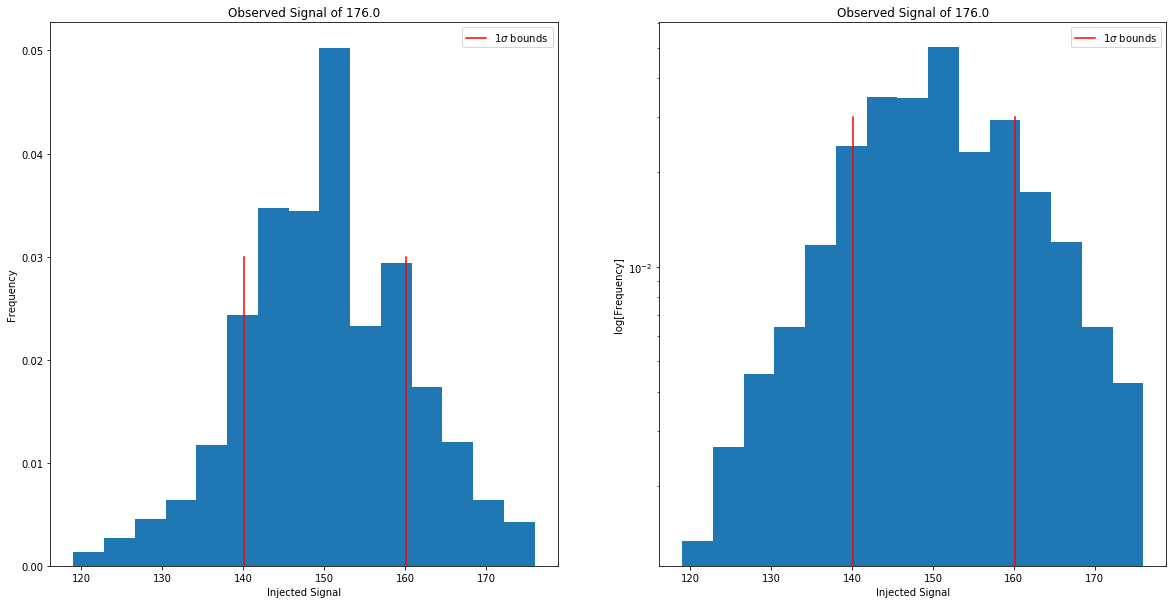

In [36]:
minus_sigma_x = [mu - sigma, mu - sigma]
plus_sigma_x = [mu + sigma, mu + sigma]
y_vals = [0, 0.03]

plt.rcParams["figure.figsize"] = (20,10)  
fig, ax = plt.subplots(1, 2)

ax[0].hist(vert_dist, bins=15, density=True)
ax[0].set_title('Observed Signal of ' + str(signal))
ax[0].set_xlabel('Injected Signal')
ax[0].set_ylabel('Frequency')
ax[0].plot(minus_sigma_x, y_vals, color = 'red', label=r'$1\sigma$ bounds')
ax[0].plot(plus_sigma_x, y_vals, color='red')
ax[0].legend()

ax[1].hist(vert_dist, bins=15, density=True)
ax[1].set_yscale('log')
ax[1].set_title('Observed Signal of ' + str(signal))
ax[1].set_xlabel('Injected Signal')
ax[1].set_ylabel('log[Frequency]')
ax[1].plot(minus_sigma_x, y_vals, color = 'red', label=r'$1\sigma$ bounds')
ax[1].plot(plus_sigma_x, y_vals, color='red')
ax[1].legend()

> e) Discuss the answer to part d in some depth. Is it symmetric? Is it biased? Does this make sense?

To answer this, I will first zoom in on the injected signal histogram in order to better see the variations in the distribution.

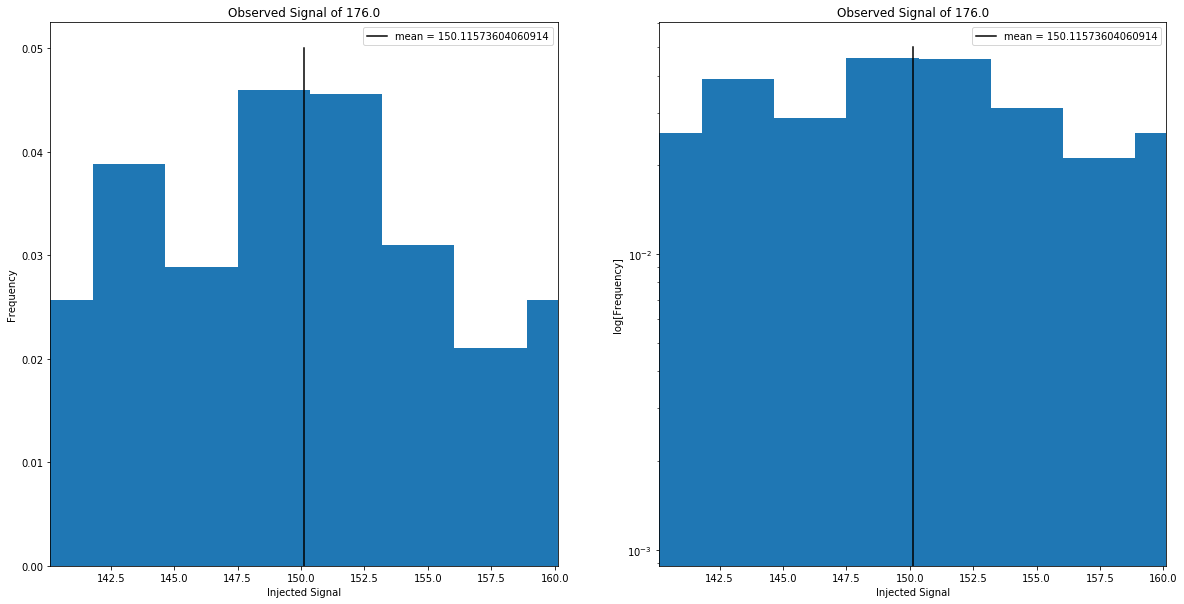

In [38]:
plt.rcParams["figure.figsize"] = (20,10)  
fig, ax = plt.subplots(1, 2)

ax[0].hist(vert_dist, bins=20, density=True)
ax[0].set_title('Observed Signal of ' + str(signal))
ax[0].set_xlabel('Injected Signal')
ax[0].set_ylabel('Frequency')
ax[0].set_xlim([mu - sigma, mu + sigma])
ax[0].plot([mu, mu], [0, 0.05], color='black', label='mean = ' + str(mu))
ax[0].legend()


ax[1].hist(vert_dist, bins=20, density=True)
ax[1].set_yscale('log')
ax[1].set_title('Observed Signal of ' + str(signal))
ax[1].set_xlabel('Injected Signal')
ax[1].set_ylabel('log[Frequency]')
ax[1].set_xlim([mu - sigma, mu + sigma])
ax[1].plot([mu, mu], [0, 0.05], color='black', label='mean = ' + str(mu))
ax[1].legend()

The black line on these histograms represent the mean value.  The distribution appears to have be slightly skewed to the right.  The distribution is not significantly biased since the mean of the injected signal is very close to the expected value of 150.  The skewness of the distribution makes sense sinse Poisson distributions are always right skewed since they are bounded as $[0, \inf)$.

## Problem 4

> Using the same setup as in problem 3, now pick a relatively weak signal (say in the 1$\sigma$ range, exact strength not important).

I will use a value of 102 for my signal strength.

> a) Repeat problem 3c, calculating the injected signal pdf(). One of the differences you should immediately see is that the pdf() extends to zero.

Text(0, 0.5, 'log[Frequency]')

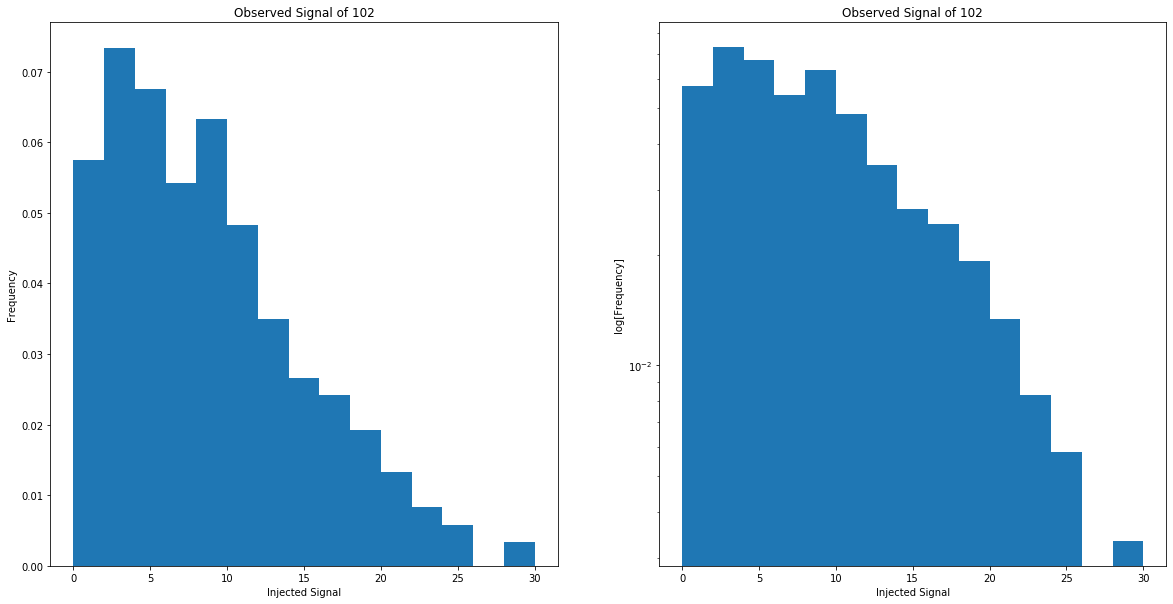

In [40]:
signal = 102

vert_dist = []

for index in range(observed.size):
    if observed[index] == signal:
        vert_dist.append(injected_signals[index])

plt.rcParams["figure.figsize"] = (20,10)  
fig, ax = plt.subplots(1, 2)

ax[0].hist(vert_dist, bins=15, density=True)
ax[0].set_title('Observed Signal of ' + str(signal))
ax[0].set_xlabel('Injected Signal')
ax[0].set_ylabel('Frequency')

ax[1].hist(vert_dist, bins=15, density=True)
ax[1].set_yscale('log')
ax[1].set_title('Observed Signal of ' + str(signal))
ax[1].set_xlabel('Injected Signal')
ax[1].set_ylabel('log[Frequency]')

> b) Describe what it means to have the true signal pdf() extend to zero.

An injected signal of 0 means that there is no true signal, that is, that we did not actually detect anything other than the background noise.

> c) Calculate a 95% confidence upper bound. 

In [41]:
conf = 0.95
bound = 1
area = 0

while area < conf:
    bound += 0.01
    count = 0
    for value in vert_dist:
        if value < bound:
            count += 1
            
    area = count / len(vert_dist)
    
print("95% confidence upper-bound: ",bound)

95% confidence upper-bound:  20.000000000000327


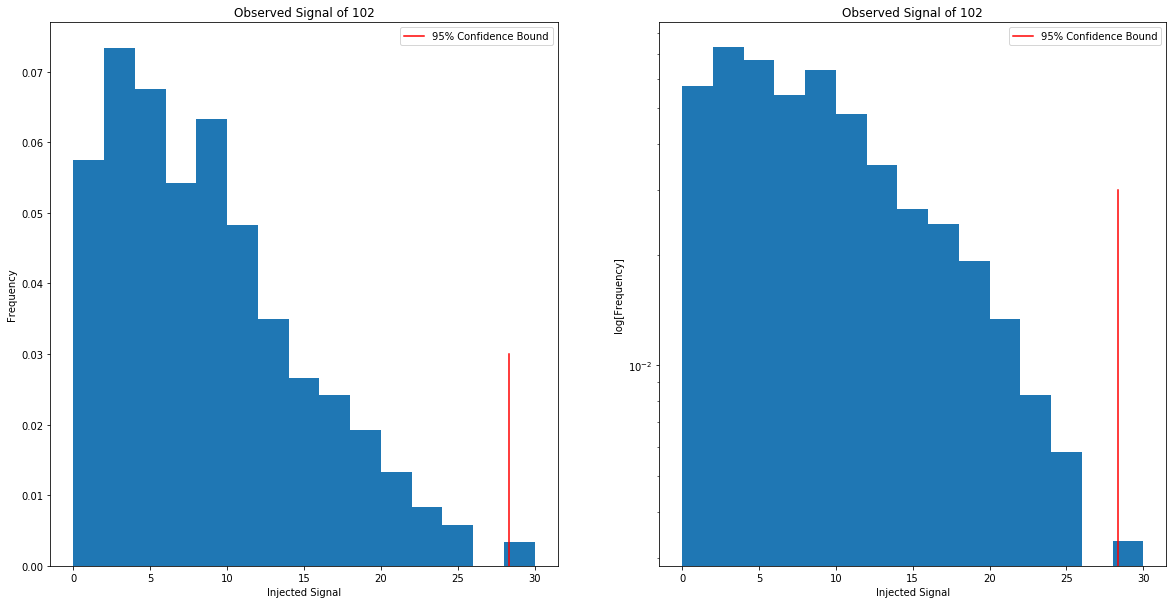

In [43]:
mu = np.average(vert_dist)

bounds = [mu + bound, mu + bound]
y_vals = [0, 0.03]

plt.rcParams["figure.figsize"] = (20,10)  
fig, ax = plt.subplots(1, 2)

ax[0].hist(vert_dist, bins=15, density=True)
ax[0].set_title('Observed Signal of ' + str(signal))
ax[0].set_xlabel('Injected Signal')
ax[0].set_ylabel('Frequency')
ax[0].plot(bounds, y_vals, color = 'red', label='95% Confidence Bound')
ax[0].legend()

ax[1].hist(vert_dist, bins=15, density=True)
ax[1].set_yscale('log')
ax[1].set_title('Observed Signal of ' + str(signal))
ax[1].set_xlabel('Injected Signal')
ax[1].set_ylabel('log[Frequency]')
ax[1].plot(bounds, y_vals, color = 'red', label='95% Confidence Bound')
ax[1].legend()